In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as met 

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import pipeline as pl

In [2]:
df = pd.read_csv("1_credit-card-default.csv")
df.head()

df.rename(columns={"PAY_0":"PAY_1"},inplace=True)

for i in df.columns:
    df[i] = pd.to_numeric(df[i], errors="coerce")
    
tmp = df.isnull().sum()
for i in tmp[tmp>0].index:
    df.loc[df[i].isna(), i] = df[i].median()
    
df.EDUCATION = df.EDUCATION.astype(int)
df.MARRIAGE = df.MARRIAGE.astype(int)
df.AGE = df.AGE.astype(int)
df.PAY_1 = df.PAY_1.astype(int)
df.PAY_2 = df.PAY_2.astype(int)
df.PAY_3 = df.PAY_3.astype(int)
df.PAY_4 = df.PAY_4.astype(int)
df.PAY_5 = df.PAY_5.astype(int)
df.PAY_6 = df.PAY_6.astype(int)

tmp = df[(df.BILL_AMT1==0)&(df.BILL_AMT2==0)&(df.BILL_AMT3==0)&(df.BILL_AMT4==0)&(df.BILL_AMT5==0)&(df.BILL_AMT6==0)]
dfval = df.loc[~df.index.isin(tmp.index)]

dfval.reset_index(drop=True,inplace=True)

In [5]:
dfval.describe()

ID       LIMIT_BAL        GENDER     EDUCATION      MARRIAGE  \
count  29134.000000    29134.000000  29134.000000  29134.000000  29134.000000   
mean   15008.173543   166140.924006      1.602664      1.857829      1.554026   
std     8654.237897   129827.799555      0.489355      0.788722      0.522006   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7522.250000    50000.000000      1.000000      1.000000      1.000000   
50%    15014.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22489.750000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_1         PAY_2         PAY_3         PAY_4  \
count  29134.000000  29134.000000  29134.000000  29134.000000  29134.000000   
mean      35.444464     -0.013455     -0.078156     -0.111691     -0.167776   
std        9.205618      1.112193      1.169866      1.171384      1.144817   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   29134.000000   29134.000000   29134.000000   29134.000000   
mean   ...   44550.754823   41507.726059   40027.107538    5831.705739   
std    ...   64840.220385   61283.383344   60042.457986   16778.478073   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    3096.500000    2439.500000    1801.250000    1100.000000   
50%    ...   19712.500000   18874.000000   18071.000000    2235.000000   
75%    ...   56724.250000   51497.500000   50263.000000    5110.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2       PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  2.913400e+04   29134.000000   29134.000000   29134.000000   
mean   6.093630e+03    5381.013421    4969.187410    4936.487575   
std    2.335142e+04   17843.327921   15874.859476   15453.622300   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    1.000000e+03     547.000000     390.000000     380.000000   
50%    2.100000e+03    2000.000000    1600.000000    1643.500000   
75%    5.000000e+03    4772.500000    4200.000000    4225.000000   
max    1.684259e+06  896040.000000  621000.000000  426529.000000   

            PAY_AMT6     defaulted  
count   29134.000000  29134.000000  
mean     5359.183291      0.216894  
std     18009.636532      0.412137  
min         0.000000      0.000000  
25%       300.000000      0.000000  
50%      1580.000000      0.000000  
75%      4170.000000      0.000000  
max    528666.000000      1.000000  

[8 rows x 25 columns]

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

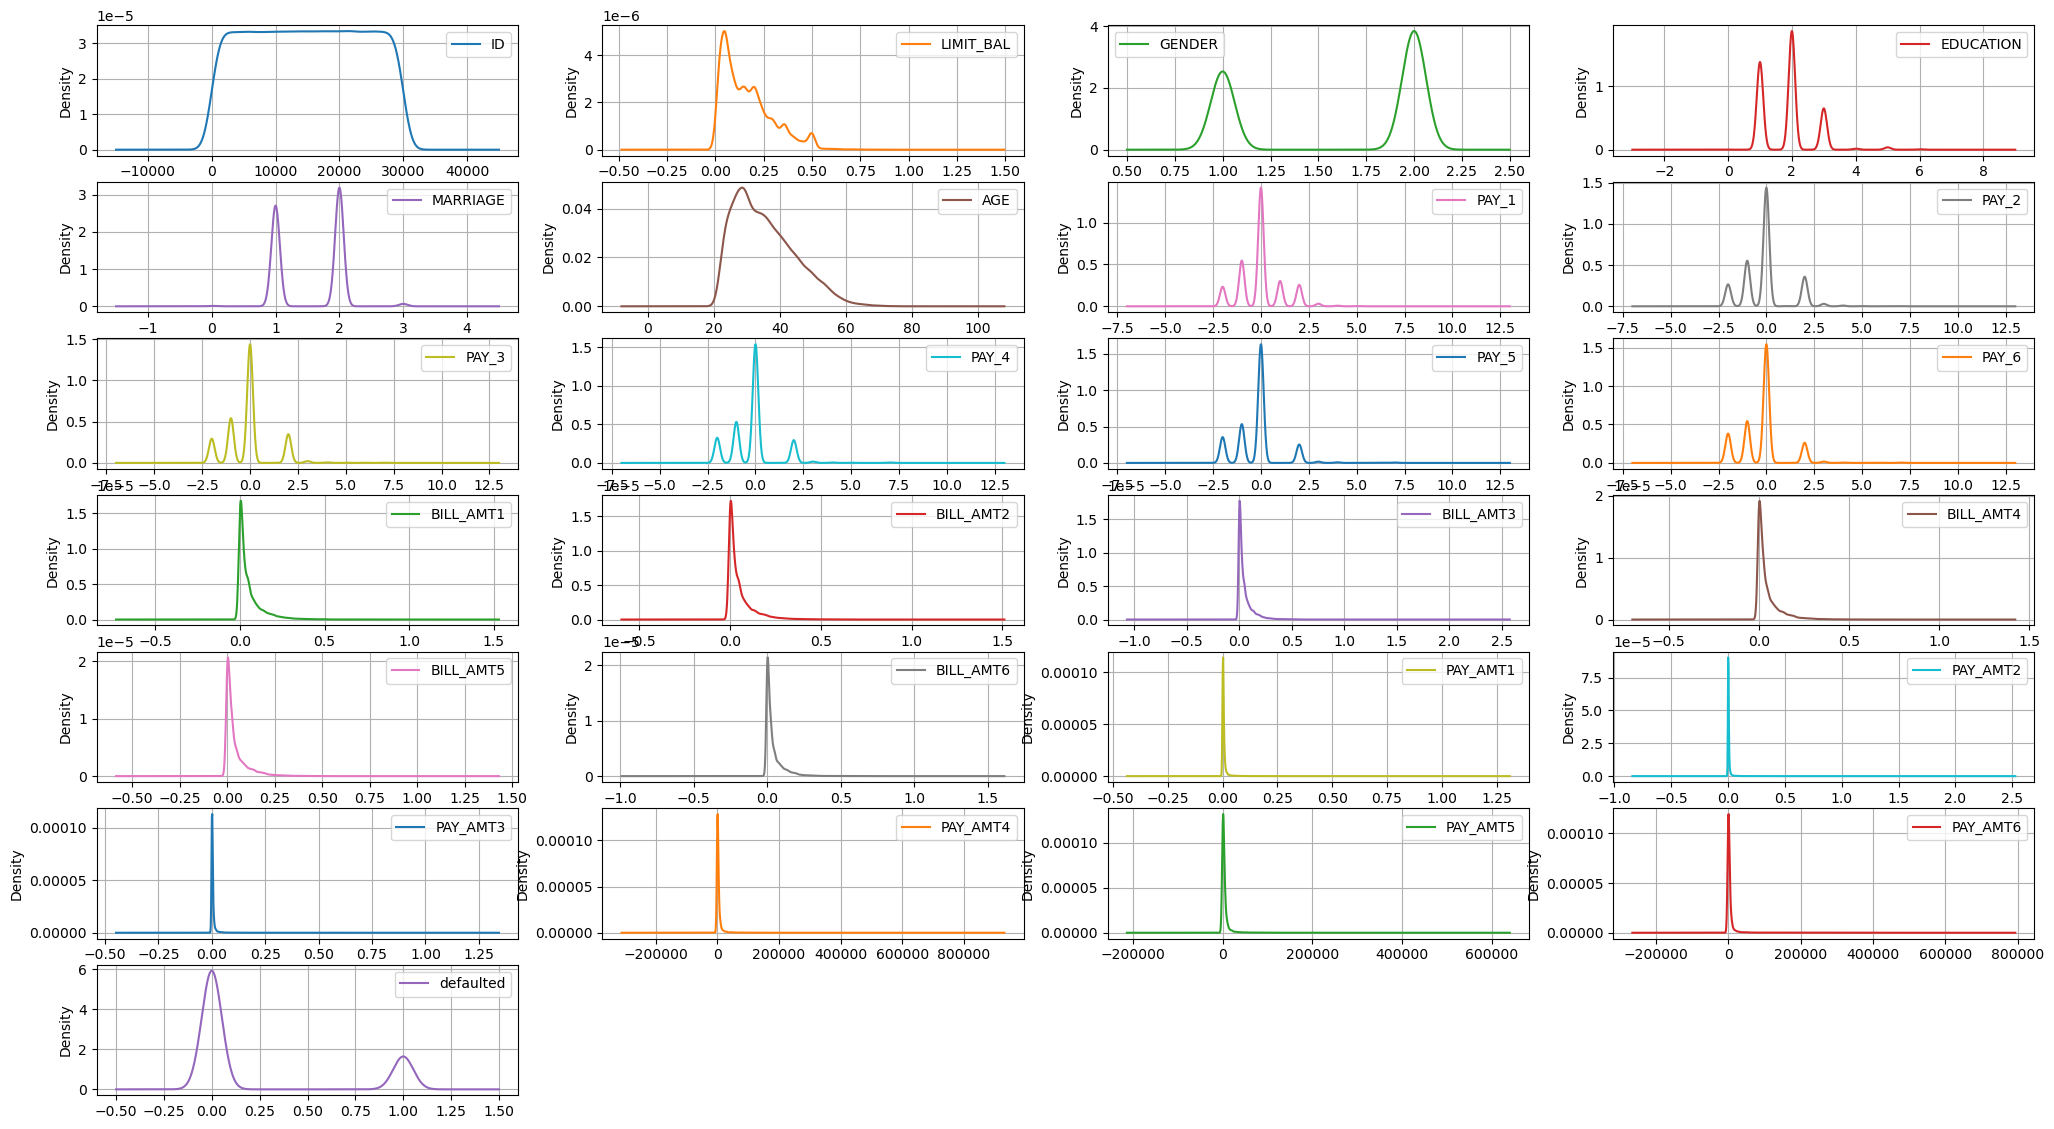

In [8]:
dfval.plot(kind='density', subplots=True, layout=(10,4), sharex=False, figsize=(25,20), grid=True)
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

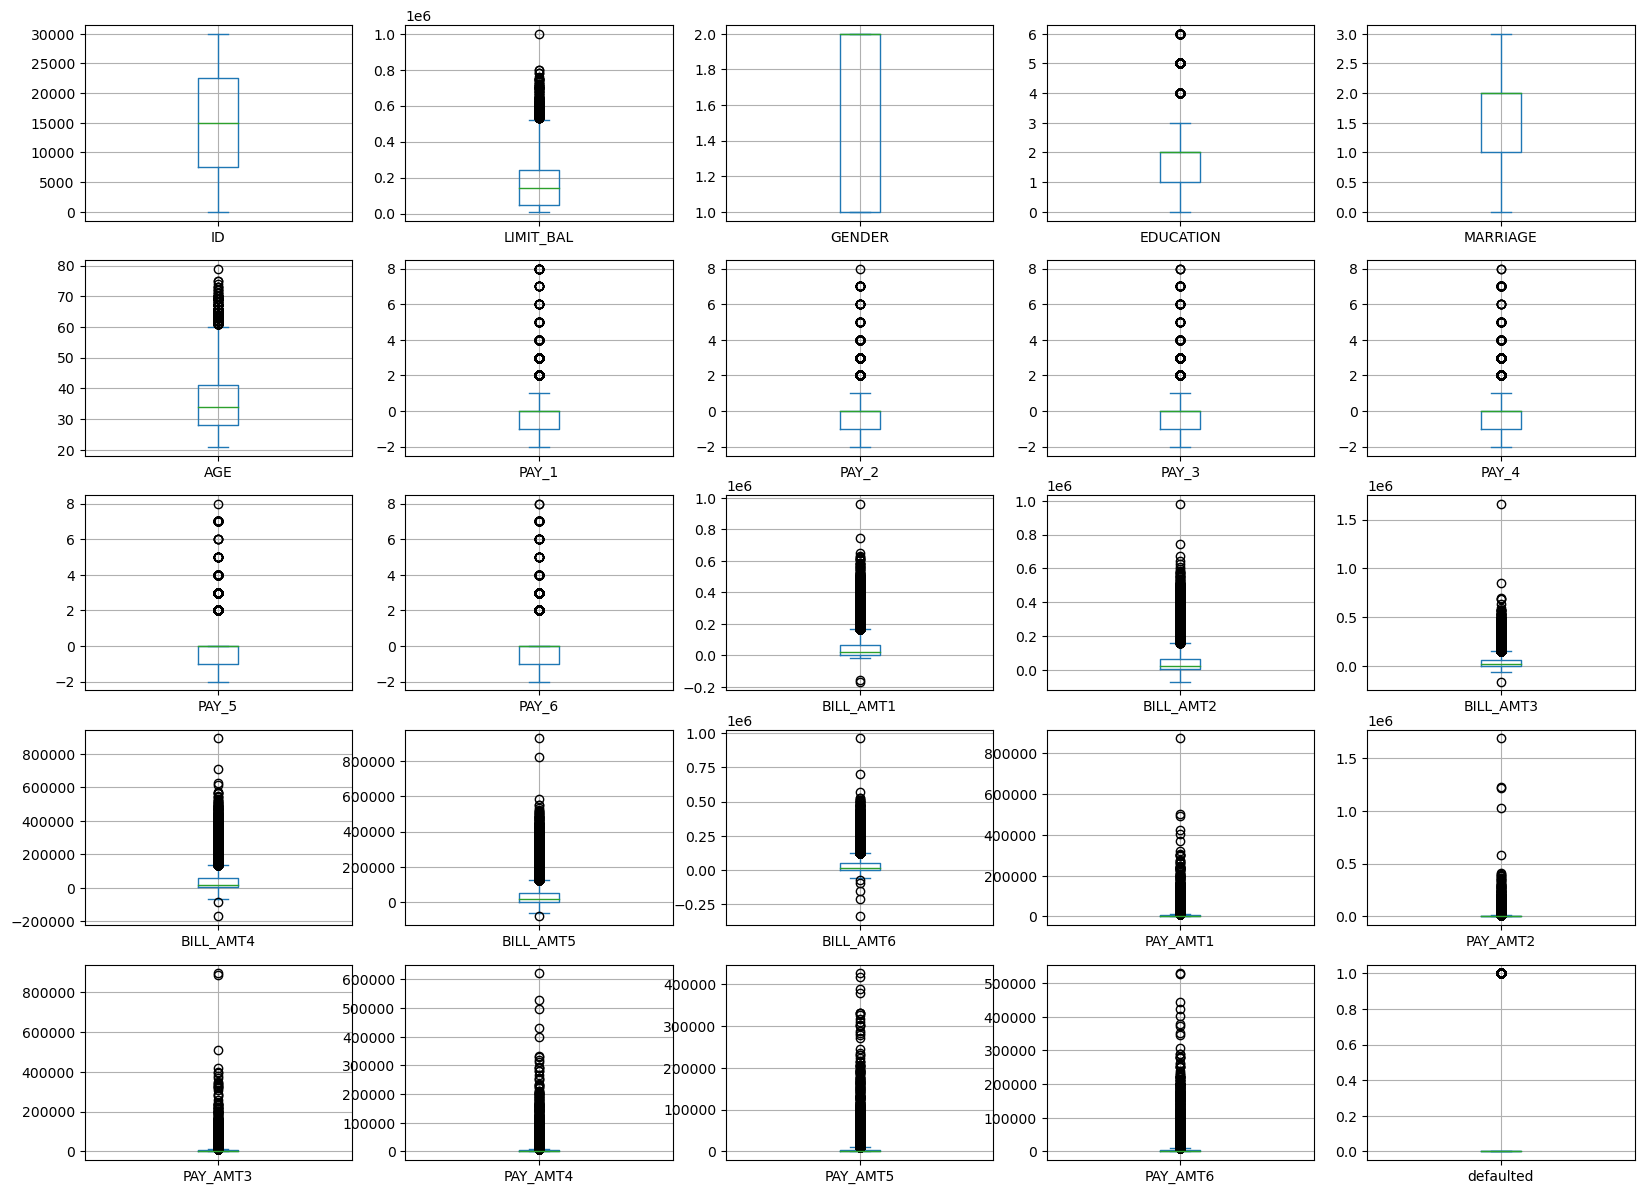

In [79]:
dfval.plot(kind='box', subplots=True, layout=(10,5), sharex=False, figsize=(20,30), grid=True)
plt.tight_layout

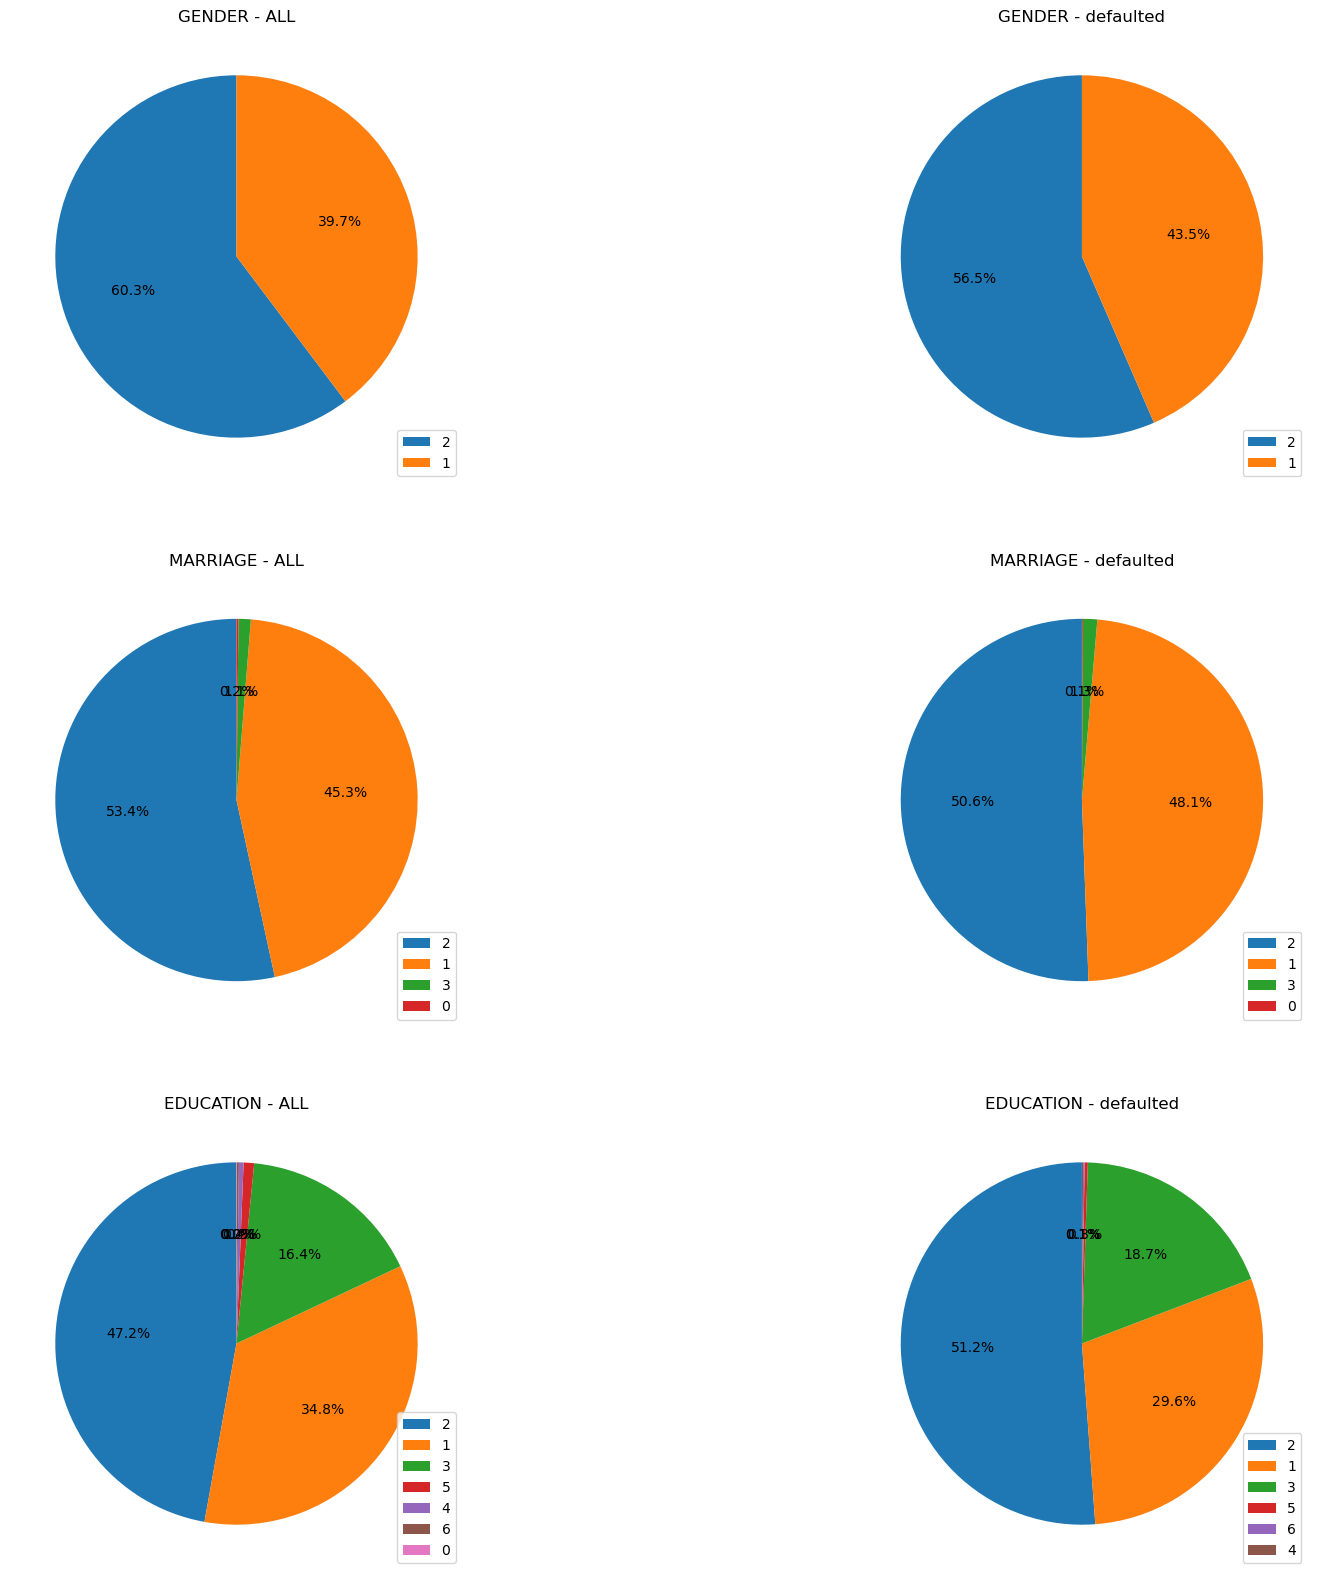

In [74]:
def bank_pie_chart(fields: list[str]):
    mx = len(fields)
    
    fig, axs = plt.subplots(mx,2,figsize=(20, 20))
    for i in range(mx):
        axs[i,0].set_title(fields[i]+ " - ALL")
        axs[i,0].pie(x=list(dfval[fields[i]].value_counts().values),autopct='%1.1f%%', startangle=90)
        axs[i,0].legend(loc= "lower right", labels=list(dfval[fields[i]].value_counts().keys()))

        axs[i,1].set_title(fields[i]+" - defaulted")
        axs[i,1].pie(x=list(dfval.loc[dfval.defaulted==1,fields[i]].value_counts().values),autopct='%1.1f%%', startangle=90)
        axs[i,1].legend(loc= "lower right", labels=list(dfval.loc[dfval.defaulted==1,fields[i]].value_counts().keys()))
        
bank_pie_chart(['GENDER', 'MARRIAGE', 'EDUCATION'])

In [22]:
cols = ["LIMIT_BAL","AGE","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
        "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]


dt1 = pd.DataFrame()
dt1["colname"] = cols
dt1["skew"] = 0
dt1["log_skew"] = 0
for i in dt1.index:
    dt1.loc[i,"skew"] = dfval[dt1.colname[i]].skew()
    dt1.loc[i,"log_skew"] = np.logdfval[dt1.colname[i]].skew()
    
dt1

colname       skew  log_skew
0   LIMIT_BAL   1.015976 -0.494908
1         AGE   0.726870  0.241349
2   BILL_AMT1   2.631165       NaN
3   BILL_AMT2   2.672274       NaN
4   BILL_AMT3   3.055629       NaN
5   BILL_AMT4   2.787445       NaN
6   BILL_AMT5   2.841708       NaN
7   BILL_AMT6   2.810511       NaN
8    PAY_AMT1  14.501742       NaN
9    PAY_AMT2  30.100644       NaN
10   PAY_AMT3  17.007834       NaN
11   PAY_AMT4  12.745168       NaN
12   PAY_AMT5  11.010786       NaN
13   PAY_AMT6  10.512303       NaN

In [78]:
cross_tab2 = dfval.groupby(["GENDER", "MARRIAGE", "EDUCATION", "defaulted"]).size().reset_index().rename(columns={0:"count"})
cross_tab2[cross_tab2.defaulted==1].head()

GENDER  MARRIAGE  EDUCATION  defaulted  count
3        1         0          3          1      2
6        1         1          1          1    347
8        1         1          2          1    624
10       1         1          3          1    292
12       1         1          4          1      2

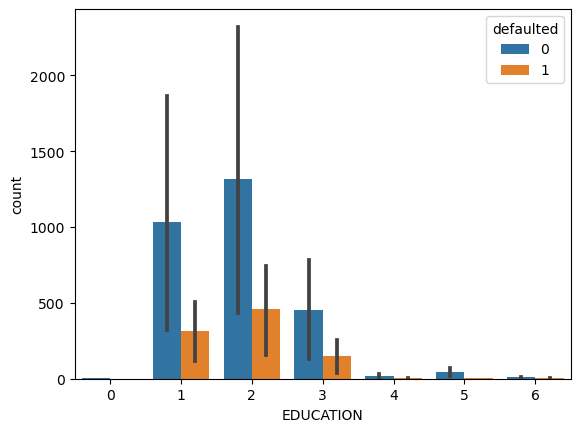

In [39]:
sns.barplot(x="EDUCATION", y="count", hue="defaulted", data=cross_tab2)
plt.show()

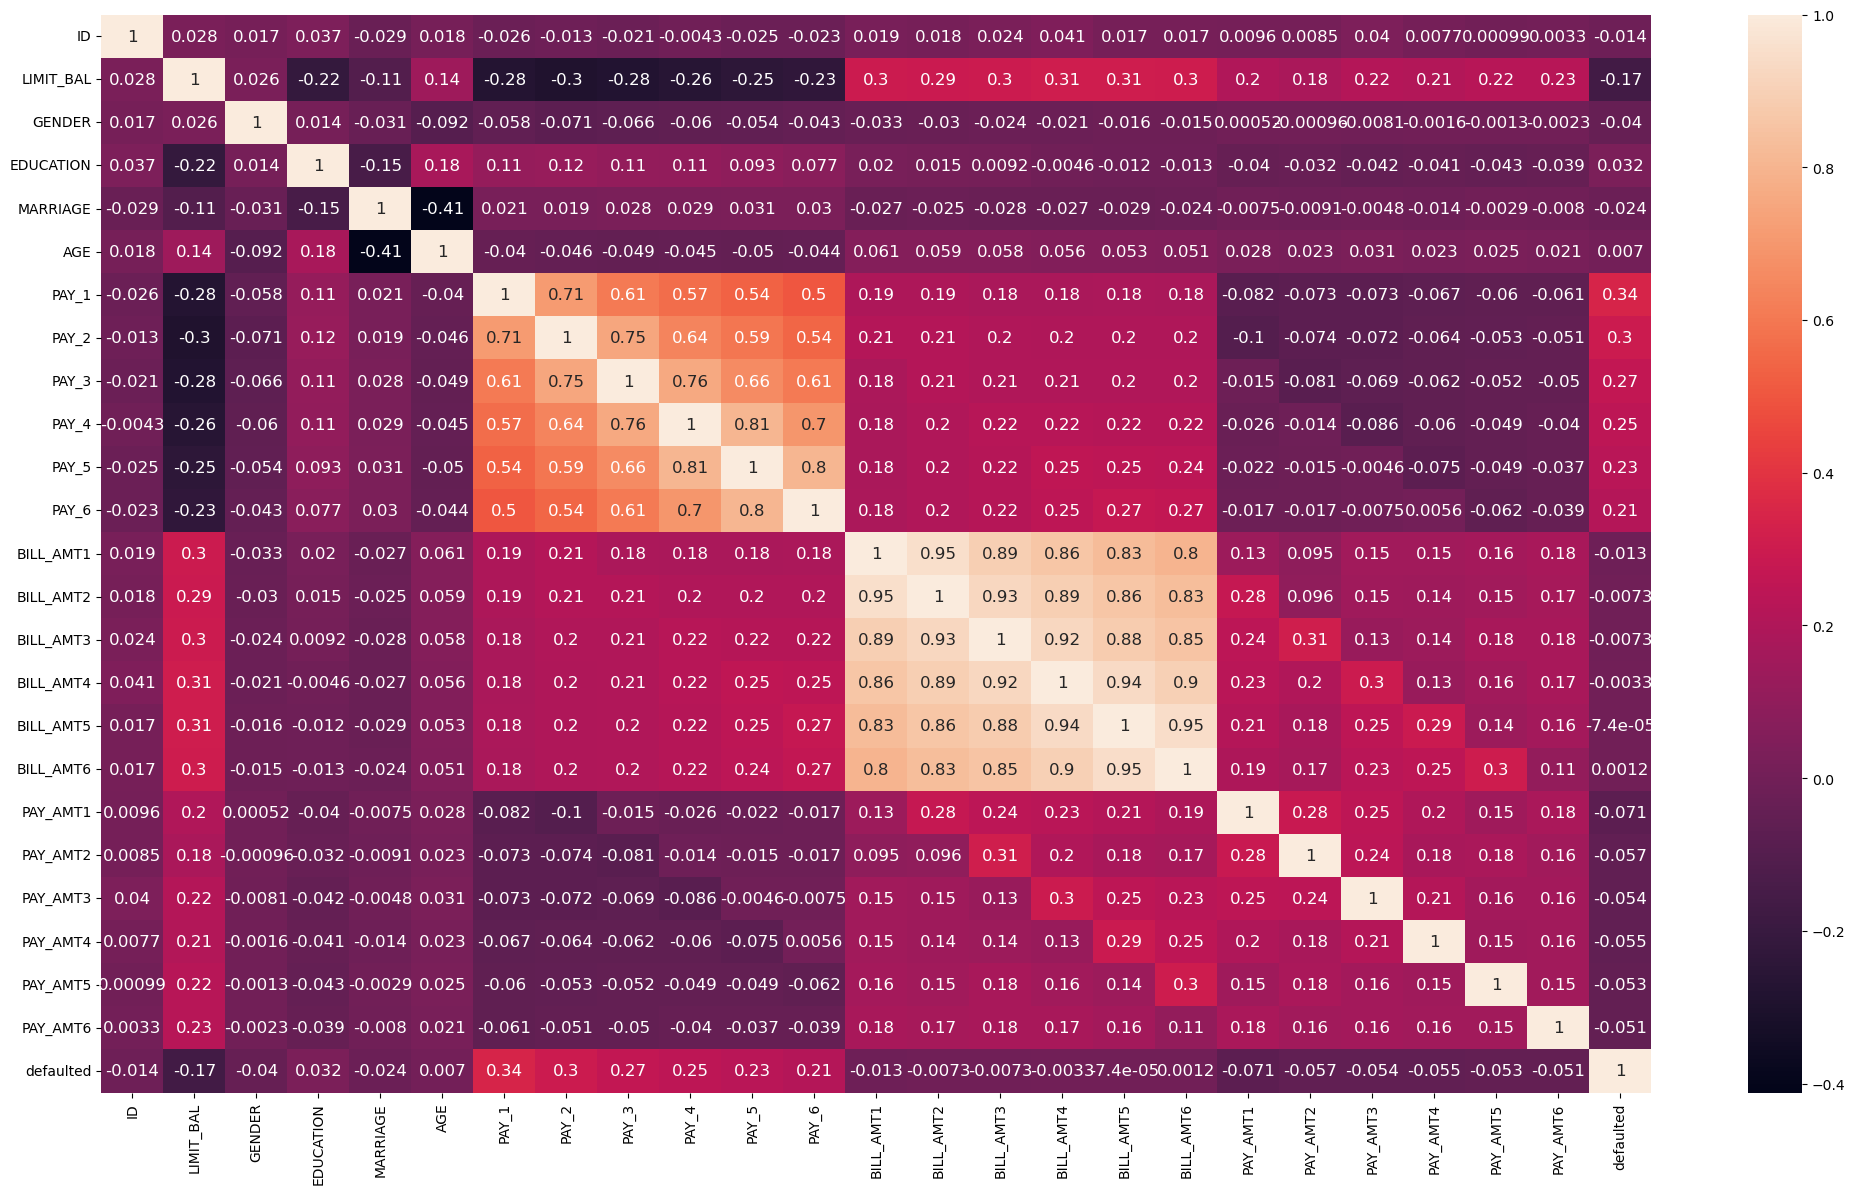

In [82]:
fig, ax = plt.subplots(figsize = (25,14))
sns.heatmap(dfval.corr(), annot = True, annot_kws = {'size':12})
plt.show()

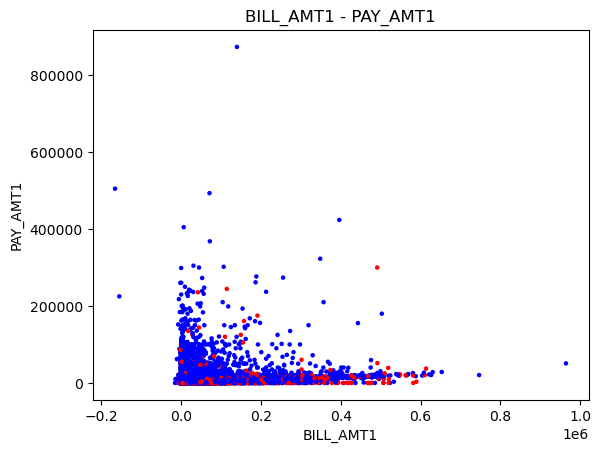

In [107]:
def show_scatter_plot(xcol,ycol,data):  
    colors = {0:"blue",1:"red"}
    plt.title(xcol + " - " + ycol)
    plt.scatter(dfval[xcol],dfval[ycol],alpha=1,s=5, c=dfval["defaulted"].map(colors))
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()
    
show_scatter_plot("BILL_AMT1","PAY_AMT1",dfval)

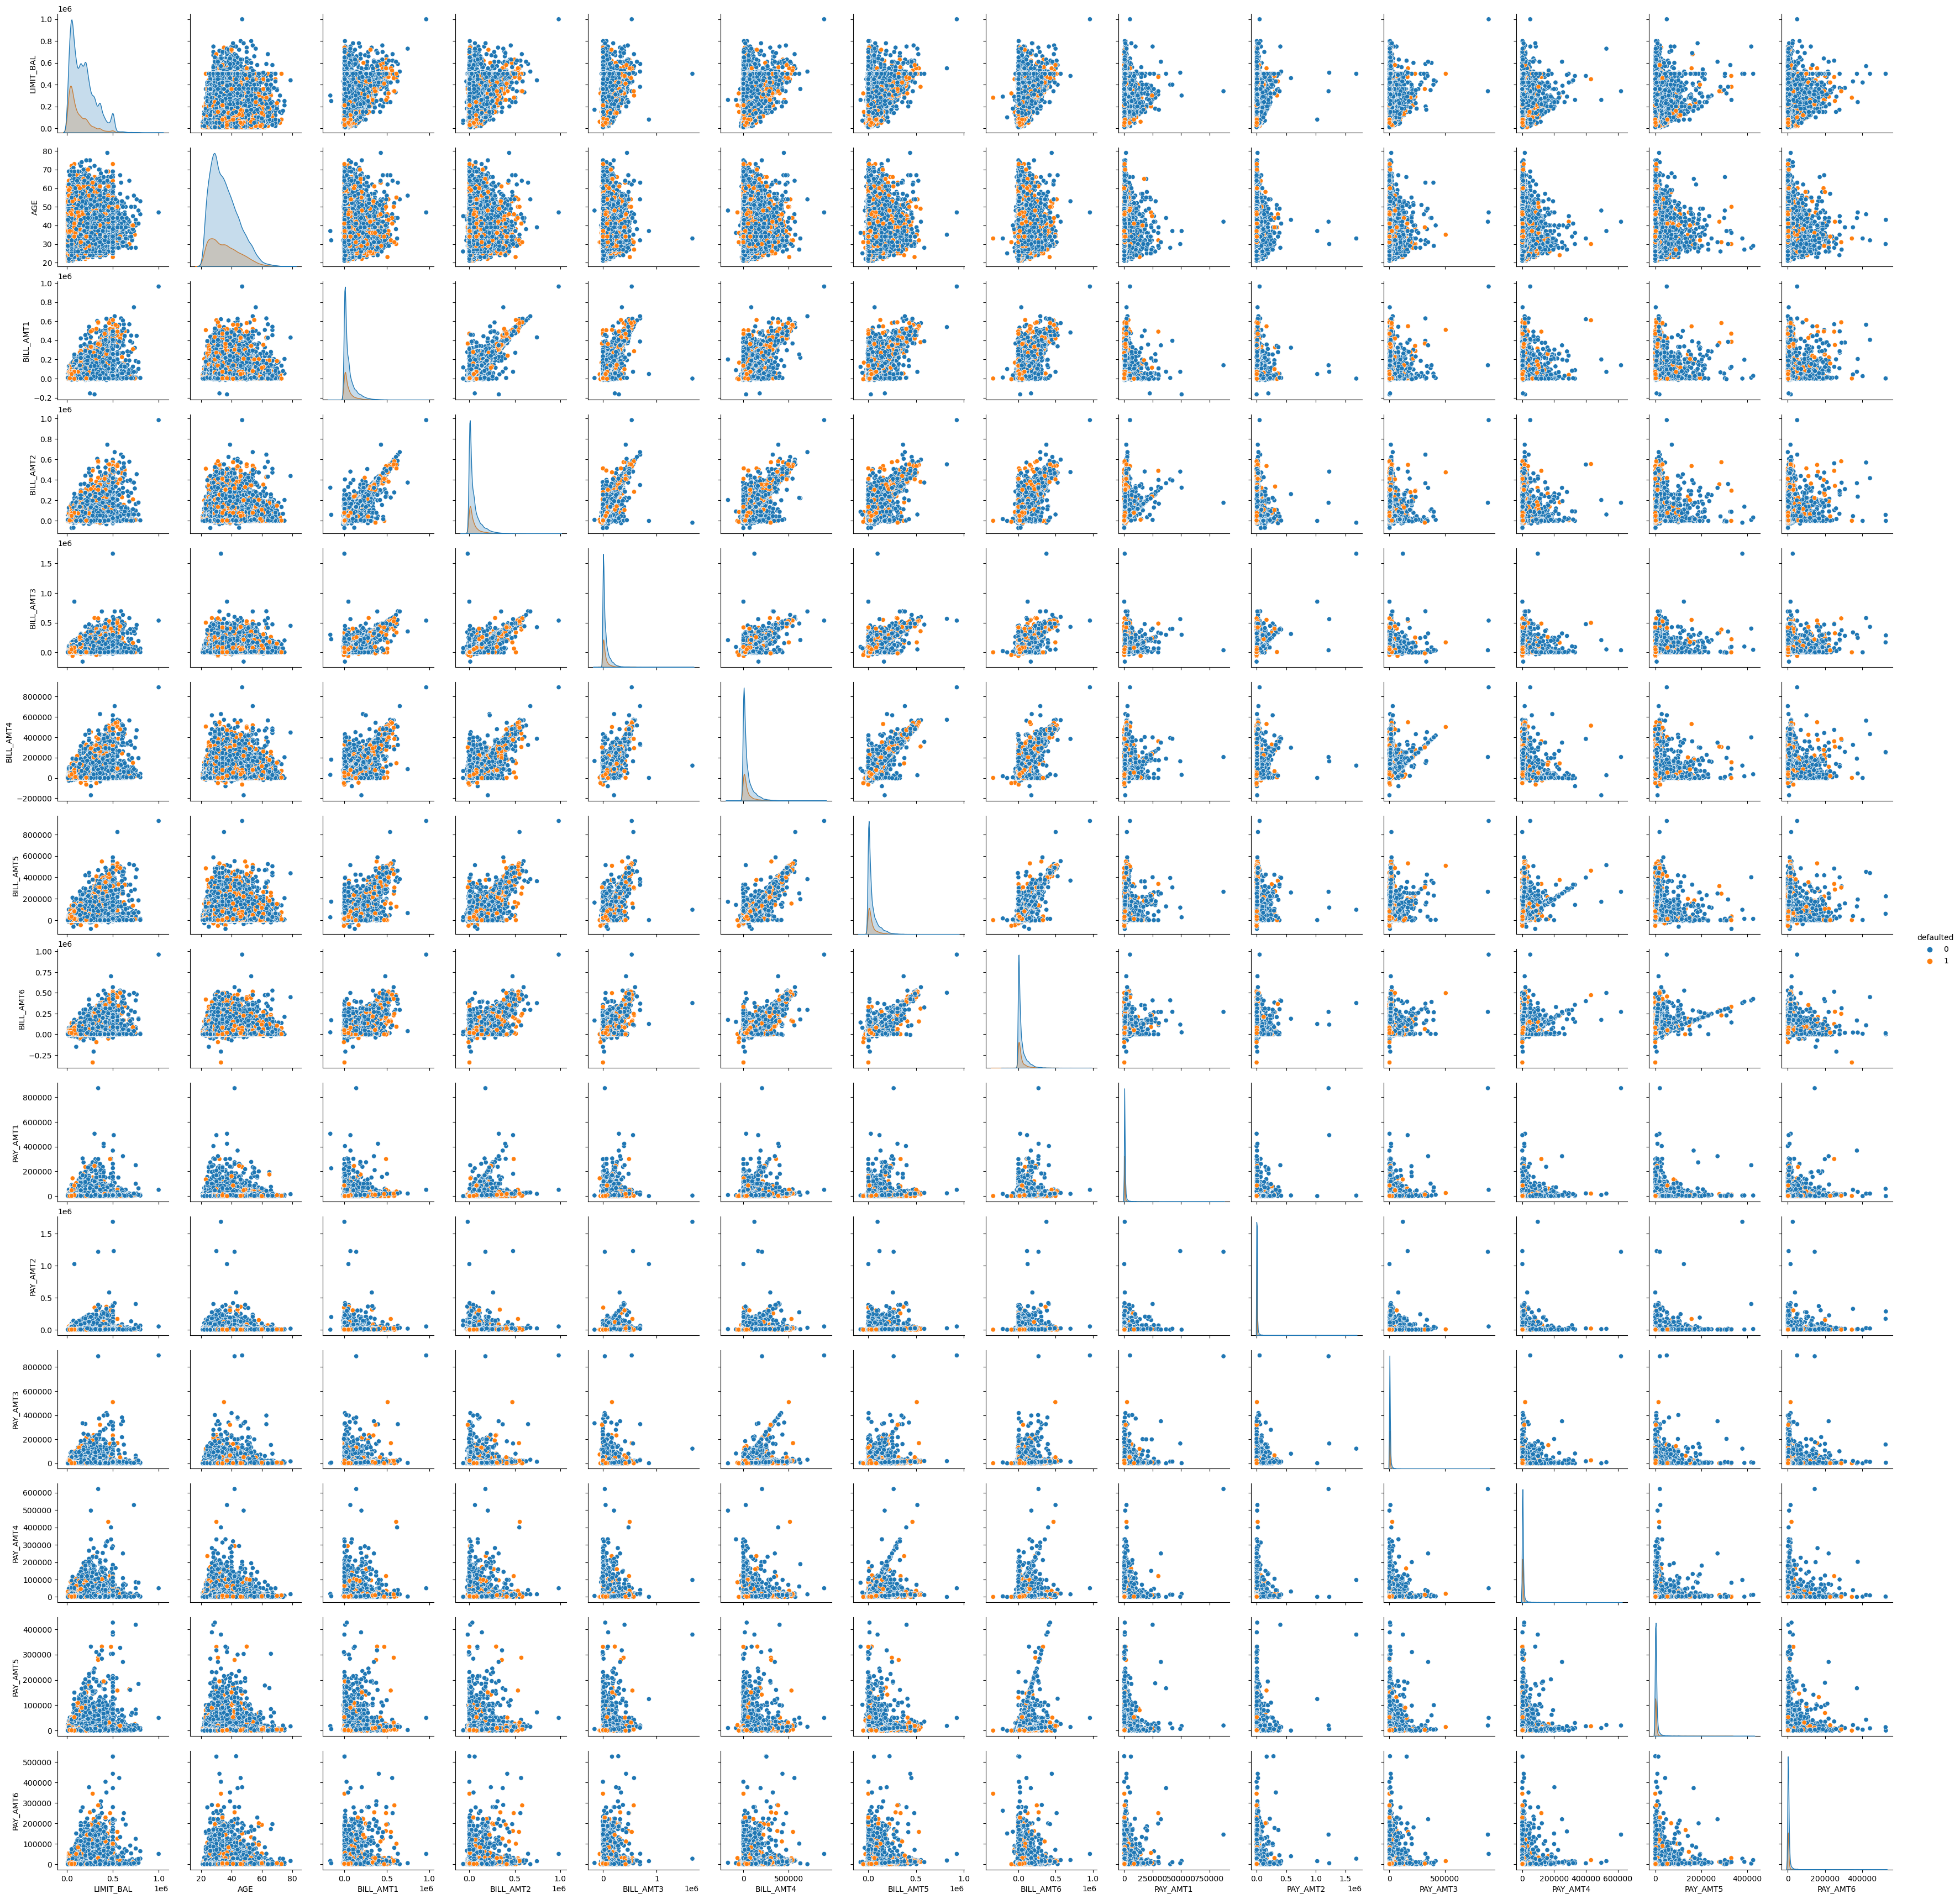

In [112]:
cols = ["LIMIT_BAL","AGE","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
        "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6","defaulted"]
sns.pairplot(dfval[cols], diag_kind='kde', hue="defaulted") # both bivariate and univariate
sns.set_context(rc={'axis.labelsize':9})
plt.show()

In [124]:
cols = ["AGE","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
        "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]

dfval["whisker"] = 0

for col in cols:
    Q1 = dfval[col].quantile(0.25) 
    Q3 = dfval[col].quantile(0.75)
    low_wis = Q1 - (1.5 * (Q3 - Q1))
    upp_wis = Q3 + (1.5 * (Q3 - Q1))

    dfval.loc[(dfval[col] < low_wis) | (dfval[col] > upp_wis), "whisker"] = 1


cat_cols = ["GENDER","MARRIAGE","EDUCATION"]
dfval_dummies = pd.get_dummies(dfval, columns = cat_cols, prefix = cat_cols, drop_first=True)

df_wis_val = dfval_dummies[dfval_dummies.whisker==0]
df_wis_out = dfval_dummies[dfval_dummies.whisker==1]

df_wis_val.reset_index(drop=True,inplace=True)
df_wis_out.reset_index(drop=True,inplace=True)

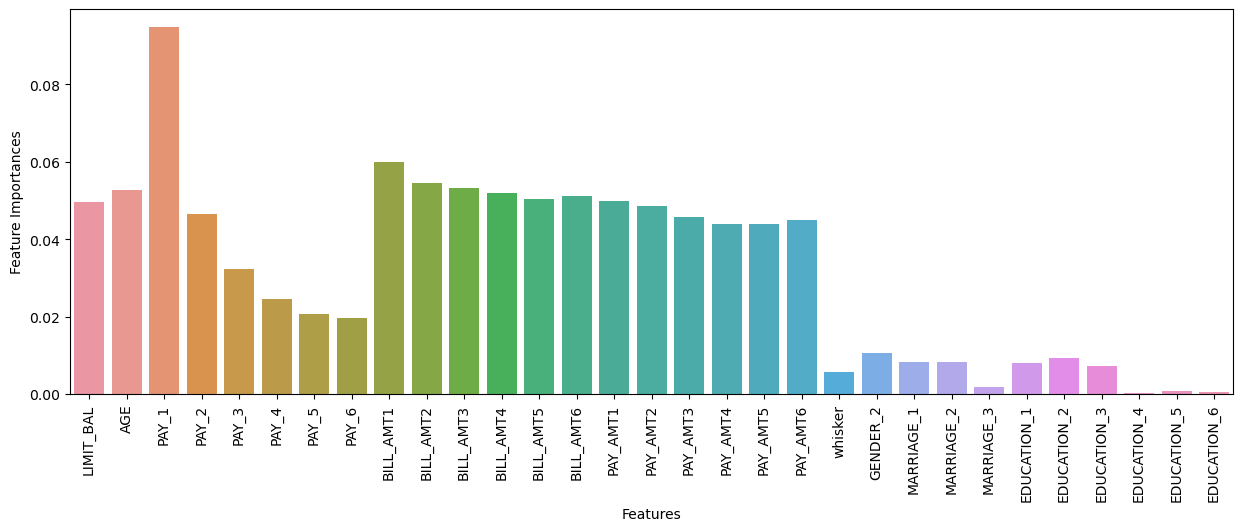

In [140]:
X = dfval_dummies.drop(columns=["ID","defaulted"])
y = dfval_dummies.defaulted
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10, random_state=2)

#dt = DecisionTreeClassifier()
dt = RandomForestClassifier()
dt.fit(X_train,y_train)
dt.feature_importances_

plt.figure(figsize=(15,5))
sns.barplot(x=X_train.columns, y=dt.feature_importances_)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Feature Importances", fontsize=10)
plt.xticks(rotation="vertical")
plt.show()

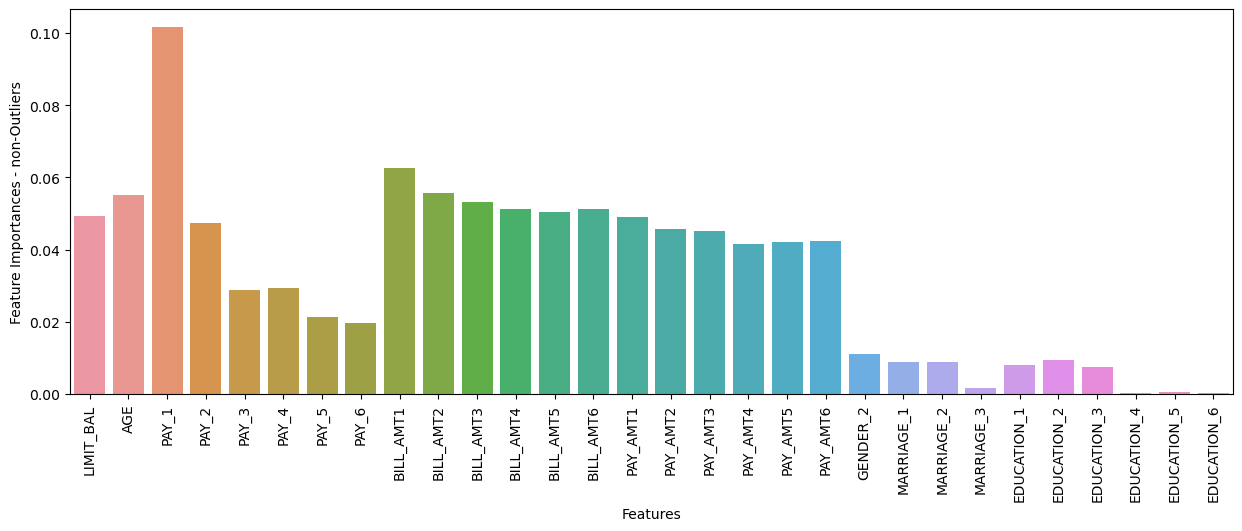

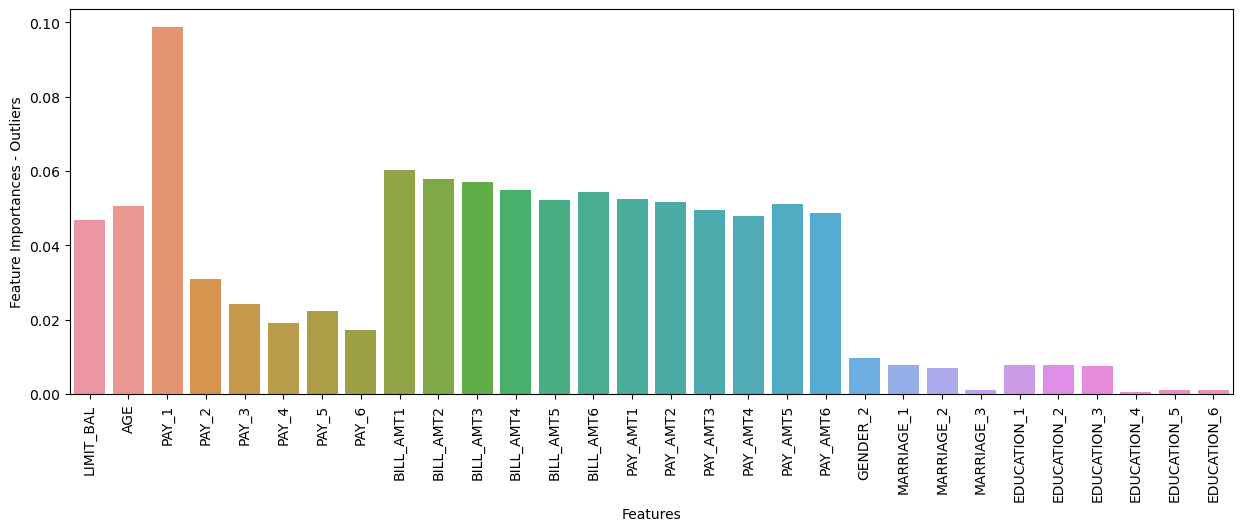

In [141]:
df_wis_val_X = df_wis_val.drop(columns=["ID","defaulted","whisker"])
df_wis_val_Y = df_wis_val.defaulted

wis_val_X_train, wis_val_X_test, wis_val_y_train, wis_val_y_test = train_test_split(df_wis_val_X,df_wis_val_Y,test_size=0.10, random_state=2)

#dt = DecisionTreeClassifier()
dt = RandomForestClassifier()
dt.fit(wis_val_X_train,wis_val_y_train)
dt.feature_importances_

plt.figure(figsize=(15,5))
sns.barplot(x=wis_val_X_train.columns, y=dt.feature_importances_)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Feature Importances - non-Outliers", fontsize=10)
plt.xticks(rotation="vertical")
plt.show()


df_wis_out_X = df_wis_out.drop(columns=["ID","defaulted","whisker"])
df_wis_out_Y = df_wis_out.defaulted

wis_out_X_train, wis_out_X_test, wis_out_y_train, wis_out_y_test = train_test_split(df_wis_out_X,df_wis_out_Y,test_size=0.10, random_state=2)


#dt = DecisionTreeClassifier()
dt = RandomForestClassifier()
dt.fit(wis_out_X_train,wis_out_y_train)
dt.feature_importances_

plt.figure(figsize=(15,5))
sns.barplot(x=wis_out_X_train.columns, y=dt.feature_importances_)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Feature Importances - Outliers", fontsize=10)
plt.xticks(rotation="vertical")
plt.show()


In [166]:
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

data_x = dfval[cols]
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = dfval.defaulted

param_dist = {
              "n_estimators":[5,20,50,100],
              "max_depth": [1,2,3,4,5,6,7,8],
              "max_features": [1,2,3,4,5,6,7,8],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["gini", "entropy"]}

tree = RandomForestClassifier()

tree_cv = RandomizedSearchCV(tree, param_distributions=param_dist, cv=5, random_state=0,verbose=1)

tree_cv.fit(data_x, data_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned Decision Tree Parameters: {'n_estimators': 100, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 8, 'criterion': 'gini'}


In [167]:
#cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER_1","GENDER_2","MARRIAGE_1","MARRIAGE_2","EDUCATION_1","EDUCATION_2","EDUCATION_3"]
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

scaler = StandardScaler()
X = scaler.fit_transform(dfval[cols])
y = dfval.defaulted

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

model = RandomForestClassifier(min_samples_leaf= 2, max_features= 7, max_depth = 4, criterion = 'gini', n_estimators = 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
'''
tmp = met.confusion_matrix(y_test,y_pred)

print("desc:", "RandomForest - valid data",
       ",  accuracy:" , round((tmp[0,0]+tmp[1,1]) / tmp.sum(),2),
       ",  precision:" , round(tmp[1,1] / (tmp[0,1]+tmp[1,1]),2),
       ",  recall:" , round(tmp[1,1] / (tmp[1,0]+tmp[1,1]),2)
     )
'''
print(met.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4545
           1       0.72      0.33      0.45      1282

    accuracy                           0.82      5827
   macro avg       0.78      0.64      0.67      5827
weighted avg       0.81      0.82      0.80      5827



In [165]:
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

data_x = dfval[cols]
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = dfval.defaulted

param_dist = {"max_depth": [1,2,3,4,5,6,7,8],
              "max_features": [1,2,3,4,5,6,7,8],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()

tree_cv = RandomizedSearchCV(tree, param_distributions=param_dist, cv=5, random_state=0,verbose=1)

tree_cv.fit(data_x, data_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned Decision Tree Parameters: {'min_samples_leaf': 8, 'max_features': 7, 'max_depth': 4, 'criterion': 'gini'}


In [175]:
#cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER_1","GENDER_2","MARRIAGE_1","MARRIAGE_2","EDUCATION_1","EDUCATION_2","EDUCATION_3"]
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

scaler = StandardScaler()
X = scaler.fit_transform(dfval[cols])
y = dfval.defaulted

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

model = DecisionTreeClassifier(min_samples_leaf= 8, max_features= 7, max_depth = 4, criterion = 'gini')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
'''
tmp = met.confusion_matrix(y_test,y_pred)

print("desc:", "RandomForest - valid data",
       ",  accuracy:" , round((tmp[0,0]+tmp[1,1]) / tmp.sum(),2),
       ",  precision:" , round(tmp[1,1] / (tmp[0,1]+tmp[1,1]),2),
       ",  recall:" , round(tmp[1,1] / (tmp[1,0]+tmp[1,1]),2)
     )
'''
print(met.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      4545
           1       0.72      0.33      0.45      1282

    accuracy                           0.82      5827
   macro avg       0.78      0.65      0.67      5827
weighted avg       0.81      0.82      0.80      5827



In [177]:

cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

scaler = StandardScaler()
X = scaler.fit_transform(dfval[cols])
y = dfval.defaulted
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

for i in range(3,10,2):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("--------- K = {0} ---------".format(i))
    print(met.classification_report(y_test,y_pred))

--------- K = 3 ---------
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      4545
           1       0.49      0.35      0.41      1282

    accuracy                           0.78      5827
   macro avg       0.66      0.62      0.64      5827
weighted avg       0.76      0.78      0.76      5827

--------- K = 5 ---------
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      4545
           1       0.56      0.34      0.43      1282

    accuracy                           0.80      5827
   macro avg       0.70      0.63      0.65      5827
weighted avg       0.77      0.80      0.78      5827

--------- K = 7 ---------
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4545
           1       0.61      0.34      0.44      1282

    accuracy                           0.81      5827
   macro avg       0.72      0.64      0.66      5

In [ ]:
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

data_x = dfval[cols]
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = dfval.defaulted

param_dist = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}

tree = SVC()

tree_cv = GridSearchCV(tree,param_dist)

tree_cv.fit(data_x, data_y)



In [180]:
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

data_x = dfval[cols]
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = dfval.defaulted

model = SVC(kernel='linear')
model.fit(data_x, data_y)
y_pred = model.predict(X_test)
print(met.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      4545
           1       0.71      0.05      0.09      1282

    accuracy                           0.79      5827
   macro avg       0.75      0.52      0.49      5827
weighted avg       0.77      0.79      0.71      5827



In [181]:
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

data_x = dfval[cols]
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = dfval.defaulted

model = LogisticRegression()
model.fit(data_x, data_y)
y_pred = model.predict(X_test)
print(met.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4545
           1       0.72      0.26      0.38      1282

    accuracy                           0.81      5827
   macro avg       0.77      0.62      0.64      5827
weighted avg       0.80      0.81      0.78      5827



In [182]:
cols = ["PAY_1","BILL_AMT1","PAY_AMT1","AGE","LIMIT_BAL","GENDER","MARRIAGE","EDUCATION"]

data_x = dfval[cols]
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = dfval.defaulted

model = xgb.XGBClassifier()
model.fit(data_x, data_y)
y_pred = model.predict(X_test)
print(met.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      4545
           1       0.80      0.42      0.55      1282

    accuracy                           0.85      5827
   macro avg       0.83      0.69      0.73      5827
weighted avg       0.84      0.85      0.83      5827



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score

# Building the ANN model
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the ANN model
history = model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)

# Predicting the target for the testing data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calculating the F1 score
f1 = f1_score(y_test, y_pred)
print('F1 Score for the ANN model: ', f1)